In [139]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os
import seaborn as sb
import scipy
import time
from bayes_opt import BayesianOptimization 
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [2]:
import tensorflow

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
os.listdir('dataset')

['application_test.csv',
 'HomeCredit_columns_description.csv',
 'POS_CASH_balance.csv',
 'credit_card_balance.csv',
 'installments_payments.csv',
 'application_train.csv',
 'bureau.csv',
 'previous_application.csv',
 'bureau_balance.csv',
 'sample_submission.csv']

In [4]:
dataset_test = pd.read_csv('dataset/application_test.csv')
dataset_train = pd.read_csv('dataset/application_train.csv')
dataset_hc_c_d = pd.read_csv('dataset/HomeCredit_columns_description.csv',encoding="ISO-8859-1")
dataset_pos_cash_b = pd.read_csv('dataset/POS_CASH_balance.csv')
dataset_ins_pay = pd.read_csv('dataset/installments_payments.csv')
dataset_c_c_bal = pd.read_csv('dataset/credit_card_balance.csv')
dataset_br = pd.read_csv('dataset/bureau.csv')
dataset_prev_app = pd.read_csv('dataset/previous_application.csv')
dataset_br_bal = pd.read_csv('dataset/bureau_balance.csv')

In [5]:
dataset_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
dataset_train['FLAG_DOCUMENT_18'].isnull().sum()

0

In [7]:
dataset_train['FLAG_DOCUMENT_19'].isnull().sum()

0

In [8]:
dataset_train['FLAG_DOCUMENT_20'].isnull().sum()

0

In [9]:
dataset_train.shape

(307511, 122)

In [10]:
dataset_train = dataset_train.dropna(axis='columns')

In [11]:
dataset_train.shape

(307511, 55)

In [12]:
dataset_train.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,Working,...,0,0,0,0,0,0,0,0,0,0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,State servant,...,0,0,0,0,0,0,0,0,0,0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,Working,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,Working,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,Working,...,0,0,0,0,0,0,0,0,0,0
5,100008,0,Cash loans,M,N,Y,0,99000.0,490495.5,State servant,...,0,0,0,0,0,0,0,0,0,0
6,100009,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,Commercial associate,...,0,0,1,0,0,0,0,0,0,0
7,100010,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,State servant,...,0,0,0,0,0,0,0,0,0,0
8,100011,0,Cash loans,F,N,Y,0,112500.0,1019610.0,Pensioner,...,0,0,0,0,0,0,0,0,0,0
9,100012,0,Revolving loans,M,N,Y,0,135000.0,405000.0,Working,...,0,0,0,0,0,0,0,0,0,0


In [13]:
dataset_train.groupby('TARGET')['SK_ID_CURR'].nunique()

TARGET
0    282686
1     24825
Name: SK_ID_CURR, dtype: int64

In [14]:
#Using random under sampling to handle imbalanced dataset
under_sampled_dataset_train_0 = dataset_train[dataset_train.TARGET == 0].sample(30000)
under_sampled_dataset_train_1 = dataset_train[dataset_train.TARGET == 1].sample(20000)
dataset_train = pd.concat([under_sampled_dataset_train_0,under_sampled_dataset_train_1],ignore_index=True)

In [15]:
dataset_train.shape

(50000, 55)

In [16]:
dataset_train.groupby('TARGET')['SK_ID_CURR'].nunique()

TARGET
0    30000
1    20000
Name: SK_ID_CURR, dtype: int64

In [17]:
dataset_train = dataset_train.sample(frac=1).reset_index(drop=True)

In [18]:
dataset_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,173964,1,Cash loans,F,N,Y,0,157500.0,738000.0,Pensioner,...,0,0,0,0,0,0,0,0,0,0
1,271364,0,Cash loans,F,N,Y,2,135000.0,479700.0,Commercial associate,...,0,0,0,0,0,0,0,0,0,0
2,288284,0,Cash loans,F,Y,Y,0,157500.0,1255680.0,Commercial associate,...,0,0,0,0,0,0,0,0,0,0
3,236314,0,Cash loans,M,Y,Y,0,405000.0,545040.0,Commercial associate,...,0,0,0,0,0,0,0,0,0,0
4,455754,0,Cash loans,F,N,Y,0,112500.0,932643.0,Working,...,0,0,0,0,0,0,0,0,0,0


In [19]:
dataset_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
dataset_hc_c_d.head()

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


In [21]:
dataset_pos_cash_b.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [22]:
dataset_ins_pay.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [23]:
dataset_c_c_bal.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [25]:
dataset_br.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [26]:
dataset_prev_app.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
dataset_br_bal.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [28]:
dataset_train = dataset_train.dropna(axis='rows')

In [29]:
dataset_train["TARGET"].value_counts(dropna=False)

0    30000
1    20000
Name: TARGET, dtype: int64

In [31]:
dataset_train["ORGANIZATION_TYPE"].value_counts(dropna=False)

Business Entity Type 3    11685
XNA                        7886
Self-employed              6835
Other                      2751
Medicine                   1713
Business Entity Type 2     1710
Government                 1547
Trade: type 7              1293
School                     1291
Construction               1277
Kindergarten               1080
Business Entity Type 1      999
Transport: type 4           956
Trade: type 3               625
Industry: type 3            591
Security                    575
Industry: type 9            534
Housing                     512
Industry: type 11           446
Agriculture                 415
Military                    371
Postal                      367
Bank                        358
Restaurant                  352
Transport: type 2           340
Police                      337
Trade: type 2               305
Security Ministries         279
Transport: type 3           259
Services                    234
Industry: type 7            221
Industry

In [32]:
corr = dataset_train.corr(method='pearson')

In [33]:
corr

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
SK_ID_CURR,1.000000,-2.793761e-03,-0.006047,-0.007541,-0.007466,0.000665,-0.003269,0.004226,0.004837,-0.004064,...,NaN,0.006529,-0.002249,0.003825,-0.004298,0.003012,-0.002645,-0.000508,5.184248e-03,0.003790
TARGET,-0.002794,1.000000e+00,0.031869,-0.002323,-0.053835,-0.068932,0.139647,-0.079624,0.074091,0.091490,...,NaN,-0.021645,-0.024196,-0.014388,-0.019035,-0.008103,-0.016785,-0.001826,5.733008e-17,0.001826
CNT_CHILDREN,-0.006047,3.186889e-02,1.000000,0.006069,0.000066,-0.033930,0.304731,-0.220552,0.173763,-0.022114,...,NaN,0.008604,-0.006779,0.011842,0.006791,-0.001117,0.002280,-0.005897,4.925263e-03,0.002520
AMT_INCOME_TOTAL,-0.007541,-2.323043e-03,0.006069,1.000000,0.064631,0.027571,0.009050,-0.025571,0.007739,-0.000743,...,NaN,0.010203,0.006914,0.003584,0.003035,0.000891,-0.000664,0.000382,-8.181744e-04,-0.001721
AMT_CREDIT,-0.007466,-5.383471e-02,0.000066,0.064631,1.000000,0.100121,-0.083710,-0.051671,-0.007976,-0.022018,...,NaN,0.047560,0.050462,0.024000,0.058925,0.010468,0.028008,0.019444,2.722801e-02,-0.022740
REGION_POPULATION_RELATIVE,0.000665,-6.893188e-02,-0.033930,0.027571,0.100121,1.000000,-0.042497,0.004591,-0.060479,-0.008156,...,NaN,0.031691,0.033726,0.011780,0.012408,0.009036,0.011602,0.000461,-2.291299e-03,0.003249
DAYS_BIRTH,-0.003269,1.396465e-01,0.304731,0.009050,-0.083710,-0.042497,1.000000,-0.603697,0.326451,0.272422,...,NaN,0.015804,0.027923,0.017307,0.017901,0.009886,0.039181,-0.001551,1.980186e-03,0.035983
DAYS_EMPLOYED,0.004226,-7.962415e-02,-0.220552,-0.025571,-0.051671,0.004591,-0.603697,1.000000,-0.204182,-0.260661,...,NaN,-0.022130,-0.018814,-0.013195,-0.036419,-0.007011,-0.036620,-0.007209,-9.669371e-03,-0.009437
DAYS_REGISTRATION,0.004837,7.409058e-02,0.173763,0.007739,-0.007976,-0.060479,0.326451,-0.204182,1.000000,0.103803,...,NaN,0.013030,0.012244,0.012450,0.025939,-0.000692,0.014768,0.001848,2.761778e-03,0.006615
DAYS_ID_PUBLISH,-0.004064,9.149041e-02,-0.022114,-0.000743,-0.022018,-0.008156,0.272422,-0.260661,0.103803,1.000000,...,NaN,0.004293,0.008705,-0.002936,-0.002829,0.006595,0.007528,0.001122,-6.763885e-03,0.025023


In [34]:
type(corr)

pandas.core.frame.DataFrame

In [35]:
column_names = list(corr.columns.values)
columns_to_remove = []
for idx,row in corr.iterrows():
    for i in range(0,len(row)):
        if row[i] > 0.70:
            if idx != column_names[i] and idx not in columns_to_remove and column_names[i] not in columns_to_remove:
                columns_to_remove.append(idx)
                columns_to_remove.append(column_names[i])
                print(idx + " - " + column_names[i])
                print(row[i])

REGION_RATING_CLIENT - REGION_RATING_CLIENT_W_CITY
0.9510325069421655
REG_REGION_NOT_WORK_REGION - LIVE_REGION_NOT_WORK_REGION
0.8611144752344749
REG_CITY_NOT_WORK_CITY - LIVE_CITY_NOT_WORK_CITY
0.8078231565112175


In [36]:
#Columnd to remove die to high correlation
columns_to_remove

['REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY']

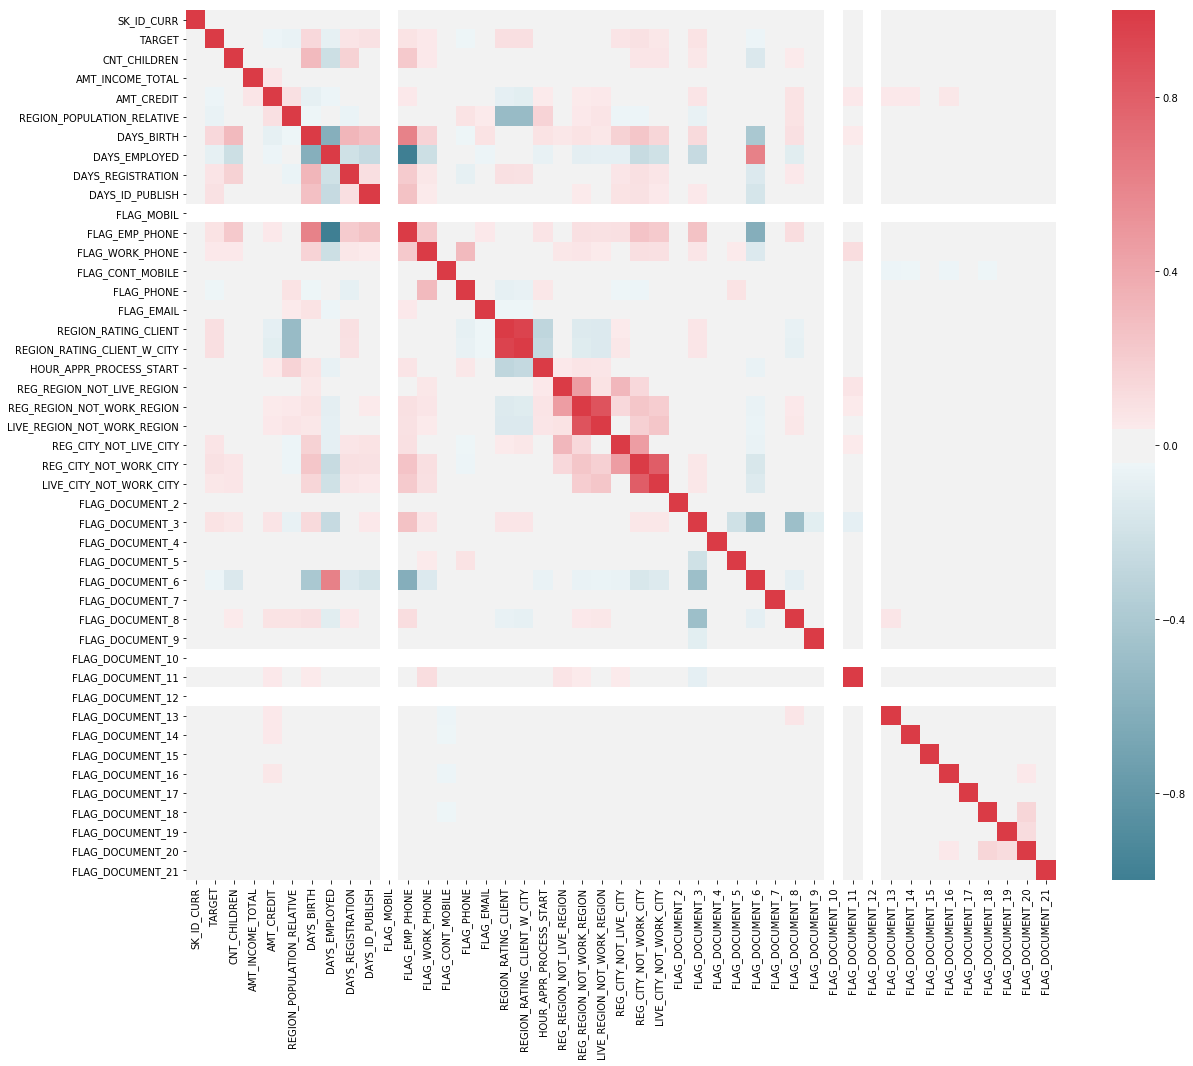

In [37]:
f,ax = plt.subplots(figsize=(20,16))
corr = dataset_train.corr()
corr_heatmap = sb.heatmap(corr,mask=np.zeros_like(corr,dtype=np.bool),cmap=sb.diverging_palette(220,10,as_cmap=True),square=True,ax=ax)
corr_figure = corr_heatmap.get_figure()
corr_figure.savefig("correlations_heatmap.png")

In [38]:
dataset_train = dataset_train.drop(columns_to_remove,axis=1)

In [39]:
dataset_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,173964,1,Cash loans,F,N,Y,0,157500.0,738000.0,Pensioner,...,0,0,0,0,0,0,0,0,0,0
1,271364,0,Cash loans,F,N,Y,2,135000.0,479700.0,Commercial associate,...,0,0,0,0,0,0,0,0,0,0
2,288284,0,Cash loans,F,Y,Y,0,157500.0,1255680.0,Commercial associate,...,0,0,0,0,0,0,0,0,0,0
3,236314,0,Cash loans,M,Y,Y,0,405000.0,545040.0,Commercial associate,...,0,0,0,0,0,0,0,0,0,0
4,455754,0,Cash loans,F,N,Y,0,112500.0,932643.0,Working,...,0,0,0,0,0,0,0,0,0,0


In [40]:
pd.set_option('display.max_columns',None)

In [132]:
dataset_train.head()

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_CITY_NOT_LIVE_CITY,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,NAME_CONTRACT_TYPE0,NAME_CONTRACT_TYPE1,CODE_GENDER0,CODE_GENDER1,FLAG_OWN_CAR0,FLAG_OWN_CAR1,FLAG_OWN_REALTY0,FLAG_OWN_REALTY1,CNT_CHILDREN0,CNT_CHILDREN1,CNT_CHILDREN2,CNT_CHILDREN3,CNT_CHILDREN4,CNT_CHILDREN5,CNT_CHILDREN6,CNT_CHILDREN7,CNT_CHILDREN8,CNT_CHILDREN9,CNT_CHILDREN10,CNT_CHILDREN11,CNT_CHILDREN12,NAME_INCOME_TYPE0,NAME_INCOME_TYPE1,NAME_INCOME_TYPE2,NAME_INCOME_TYPE3,NAME_INCOME_TYPE4,NAME_INCOME_TYPE5,NAME_INCOME_TYPE6,NAME_INCOME_TYPE7,NAME_EDUCATION_TYPE0,NAME_EDUCATION_TYPE1,NAME_EDUCATION_TYPE2,NAME_EDUCATION_TYPE3,NAME_EDUCATION_TYPE4,NAME_FAMILY_STATUS0,NAME_FAMILY_STATUS1,NAME_FAMILY_STATUS2,NAME_FAMILY_STATUS3,NAME_FAMILY_STATUS4,NAME_FAMILY_STATUS5,NAME_HOUSING_TYPE0,NAME_HOUSING_TYPE1,NAME_HOUSING_TYPE2,NAME_HOUSING_TYPE3,NAME_HOUSING_TYPE4,NAME_HOUSING_TYPE5,ORGANIZATION_TYPE0,ORGANIZATION_TYPE1,ORGANIZATION_TYPE2,ORGANIZATION_TYPE3,ORGANIZATION_TYPE4,ORGANIZATION_TYPE5,ORGANIZATION_TYPE6,ORGANIZATION_TYPE7,ORGANIZATION_TYPE8,ORGANIZATION_TYPE9,ORGANIZATION_TYPE10,ORGANIZATION_TYPE11,ORGANIZATION_TYPE12,ORGANIZATION_TYPE13,ORGANIZATION_TYPE14,ORGANIZATION_TYPE15,ORGANIZATION_TYPE16,ORGANIZATION_TYPE17,ORGANIZATION_TYPE18,ORGANIZATION_TYPE19,ORGANIZATION_TYPE20,ORGANIZATION_TYPE21,ORGANIZATION_TYPE22,ORGANIZATION_TYPE23,ORGANIZATION_TYPE24,ORGANIZATION_TYPE25,ORGANIZATION_TYPE26,ORGANIZATION_TYPE27,ORGANIZATION_TYPE28,ORGANIZATION_TYPE29,ORGANIZATION_TYPE30,ORGANIZATION_TYPE31,ORGANIZATION_TYPE32,ORGANIZATION_TYPE33,ORGANIZATION_TYPE34,ORGANIZATION_TYPE35,ORGANIZATION_TYPE36,ORGANIZATION_TYPE37,ORGANIZATION_TYPE38,ORGANIZATION_TYPE39,ORGANIZATION_TYPE40,ORGANIZATION_TYPE41,ORGANIZATION_TYPE42,ORGANIZATION_TYPE43,ORGANIZATION_TYPE44,ORGANIZATION_TYPE45,ORGANIZATION_TYPE46,ORGANIZATION_TYPE47,ORGANIZATION_TYPE48,ORGANIZATION_TYPE49,ORGANIZATION_TYPE50,ORGANIZATION_TYPE51,ORGANIZATION_TYPE52,ORGANIZATION_TYPE53,ORGANIZATION_TYPE54,ORGANIZATION_TYPE55,ORGANIZATION_TYPE56,ORGANIZATION_TYPE57
0,173964,1,157500.0,738000.0,0.030755,-16522,365243,-3950.0,-51,1,0,0,1,0,0,13,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,271364,0,135000.0,479700.0,0.009334,-15887,-2242,-3588.0,-3506,1,1,1,1,1,0,13,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,288284,0,157500.0,1255680.0,0.035792,-19377,-574,-8813.0,-2813,1,1,0,1,0,0,13,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0

In [43]:
columns_to_label_encode = ['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR',
                           'FLAG_OWN_REALTY','CNT_CHILDREN','NAME_INCOME_TYPE',
                           'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','ORGANIZATION_TYPE']
starttime = time.time()
for column in columns_to_label_encode:
    le = LabelEncoder()
    oe = OneHotEncoder()
    label_encoded = le.fit_transform(dataset_train[column])
    label_encoded = label_encoded.reshape(-1,1)
    one_hot_encoded = oe.fit_transform(label_encoded).toarray()
    df = pd.DataFrame(one_hot_encoded,columns=[column + str(i) for i in range(0,one_hot_encoded.shape[1])])
    dataset_train = pd.concat([dataset_train,df],axis=1)
    print(column + " - " + str(dataset_train.shape[0]) + " " + str(dataset_train.shape[1]))
endtime = time.time()
print("Time Elapsed:- ")
print(endtime - starttime)

NAME_CONTRACT_TYPE - 50000 51
CODE_GENDER - 50000 53
FLAG_OWN_CAR - 50000 55
FLAG_OWN_REALTY - 50000 57
CNT_CHILDREN - 50000 70
NAME_INCOME_TYPE - 50000 78
NAME_EDUCATION_TYPE - 50000 83
NAME_FAMILY_STATUS - 50000 89
NAME_HOUSING_TYPE - 50000 95
ORGANIZATION_TYPE - 50000 153
Time Elapsed:- 
0.996138334274292


In [46]:
columns_to_label_encode = ['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR',
                           'FLAG_OWN_REALTY','CNT_CHILDREN','NAME_INCOME_TYPE',
                           'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','ORGANIZATION_TYPE','WEEKDAY_APPR_PROCESS_START']
dataset_train = dataset_train.drop(columns_to_label_encode,axis=1)

In [47]:
dataset_train.shape

(50000, 142)

In [48]:
dataset_train.head()

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_CITY_NOT_LIVE_CITY,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,NAME_CONTRACT_TYPE0,NAME_CONTRACT_TYPE1,CODE_GENDER0,CODE_GENDER1,FLAG_OWN_CAR0,FLAG_OWN_CAR1,FLAG_OWN_REALTY0,FLAG_OWN_REALTY1,CNT_CHILDREN0,CNT_CHILDREN1,CNT_CHILDREN2,CNT_CHILDREN3,CNT_CHILDREN4,CNT_CHILDREN5,CNT_CHILDREN6,CNT_CHILDREN7,CNT_CHILDREN8,CNT_CHILDREN9,CNT_CHILDREN10,CNT_CHILDREN11,CNT_CHILDREN12,NAME_INCOME_TYPE0,NAME_INCOME_TYPE1,NAME_INCOME_TYPE2,NAME_INCOME_TYPE3,NAME_INCOME_TYPE4,NAME_INCOME_TYPE5,NAME_INCOME_TYPE6,NAME_INCOME_TYPE7,NAME_EDUCATION_TYPE0,NAME_EDUCATION_TYPE1,NAME_EDUCATION_TYPE2,NAME_EDUCATION_TYPE3,NAME_EDUCATION_TYPE4,NAME_FAMILY_STATUS0,NAME_FAMILY_STATUS1,NAME_FAMILY_STATUS2,NAME_FAMILY_STATUS3,NAME_FAMILY_STATUS4,NAME_FAMILY_STATUS5,NAME_HOUSING_TYPE0,NAME_HOUSING_TYPE1,NAME_HOUSING_TYPE2,NAME_HOUSING_TYPE3,NAME_HOUSING_TYPE4,NAME_HOUSING_TYPE5,ORGANIZATION_TYPE0,ORGANIZATION_TYPE1,ORGANIZATION_TYPE2,ORGANIZATION_TYPE3,ORGANIZATION_TYPE4,ORGANIZATION_TYPE5,ORGANIZATION_TYPE6,ORGANIZATION_TYPE7,ORGANIZATION_TYPE8,ORGANIZATION_TYPE9,ORGANIZATION_TYPE10,ORGANIZATION_TYPE11,ORGANIZATION_TYPE12,ORGANIZATION_TYPE13,ORGANIZATION_TYPE14,ORGANIZATION_TYPE15,ORGANIZATION_TYPE16,ORGANIZATION_TYPE17,ORGANIZATION_TYPE18,ORGANIZATION_TYPE19,ORGANIZATION_TYPE20,ORGANIZATION_TYPE21,ORGANIZATION_TYPE22,ORGANIZATION_TYPE23,ORGANIZATION_TYPE24,ORGANIZATION_TYPE25,ORGANIZATION_TYPE26,ORGANIZATION_TYPE27,ORGANIZATION_TYPE28,ORGANIZATION_TYPE29,ORGANIZATION_TYPE30,ORGANIZATION_TYPE31,ORGANIZATION_TYPE32,ORGANIZATION_TYPE33,ORGANIZATION_TYPE34,ORGANIZATION_TYPE35,ORGANIZATION_TYPE36,ORGANIZATION_TYPE37,ORGANIZATION_TYPE38,ORGANIZATION_TYPE39,ORGANIZATION_TYPE40,ORGANIZATION_TYPE41,ORGANIZATION_TYPE42,ORGANIZATION_TYPE43,ORGANIZATION_TYPE44,ORGANIZATION_TYPE45,ORGANIZATION_TYPE46,ORGANIZATION_TYPE47,ORGANIZATION_TYPE48,ORGANIZATION_TYPE49,ORGANIZATION_TYPE50,ORGANIZATION_TYPE51,ORGANIZATION_TYPE52,ORGANIZATION_TYPE53,ORGANIZATION_TYPE54,ORGANIZATION_TYPE55,ORGANIZATION_TYPE56,ORGANIZATION_TYPE57
0,173964,1,157500.0,738000.0,0.030755,-16522,365243,-3950.0,-51,1,0,0,1,0,0,13,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,271364,0,135000.0,479700.0,0.009334,-15887,-2242,-3588.0,-3506,1,1,1,1,1,0,13,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,288284,0,157500.0,1255680.0,0.035792,-19377,-574,-8813.0,-2813,1,1,0,1,0,0,13,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0

In [49]:
X = dataset_train.iloc[:,2:]
y = dataset_train['TARGET']

In [50]:
X.shape

(50000, 140)

In [51]:
y.shape

(50000,)

In [53]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=232)

In [123]:
X_train.shape

(40000, 140)

In [124]:
X_test.shape

(10000, 140)

In [152]:
def generate_classifier_report(classifier,predictions,predictions_prob,name):
    print(classification_report(y_test,predictions))
    logit_roc_score = roc_auc_score(y_test,predictions)
    fpr, tpr, thresholds = roc_curve(y_test,predictions_prob)
    plt.figure()
    plt.plot(fpr,tpr,label=name + " AUC score:- " + str(logit_roc_score))
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate (FP / (FP + TN))')
    plt.ylabel('True Positive Rate (TP / (TP + FN))')
    plt.title('Receiver Operating Characteristics Curve')
    plt.legend(loc="lower right")
    plt.savefig(name + "_roc_curve")
    plt.show()

In [81]:
clf = LogisticRegression(C=0.4)
clf.fit(X_train,y_train)

LogisticRegression(C=0.4, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [61]:
prediction = clf.predict(X_test)

In [144]:
accuracy_score(y_test,prediction)

0.6188

In [64]:
confusion_matrix(y_test,prediction)

array([[6001,    0],
       [3999,    0]])

             precision    recall  f1-score   support

          0       0.64      0.82      0.72      6001
          1       0.54      0.32      0.40      3999

avg / total       0.60      0.62      0.59     10000



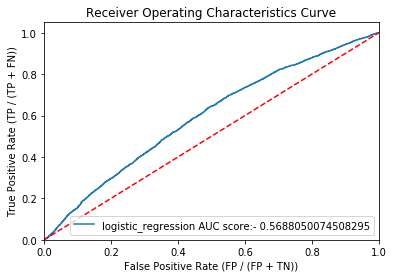

In [153]:
generate_classifier_report(clf,prediction,clf.predict_proba(X_test)[:,1],name="logistic_regression")

In [65]:
dataset_train.shape

(50000, 142)

In [133]:
classifier = RandomForestClassifier()
classifier.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [134]:
prediction = classifier.predict(X_test)

In [135]:
confusion_matrix(y_test,prediction)

array([[4912, 1089],
       [2723, 1276]])

In [136]:
accuracy_score(y_test,prediction)

0.6188

In [73]:
boosting = XGBClassifier()
boosting.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [74]:
pred = boosting.predict(X_test)
accuracy_score(y_test,pred)

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.6498

In [77]:
confusion_matrix(y_test,pred)

array([[5054,  947],
       [2555, 1444]])

In [ ]:
clf = svm.SVC(gamma=0.001, C=1.0, kernel='poly')
clf.fit(X_train,y_train)

In [ ]:
pred = clf.predict(X_test)
accuracy_score(y_test,pred)

In [ ]:
confusion_matrix(y_test,pred).ravel()